In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

In [3]:
sns.set(rc={"figure.figsize":(10, 6)})
plt.style.use("fivethirtyeight")

In [4]:
train_non_random = pd.read_csv("data/non_rand_discount.csv", delimiter=";")
test_random = pd.read_csv("data/random_data.csv")

train_non_random.head()
test_random.head()

print(train_non_random.shape)
print(test_random.shape)

train_non_random.dtypes[-10:]

train_non_random["discount"] =pd.to_numeric(train_non_random["discount"].str.split(" ", expand=True)[1])

train_non_random.dtypes[-10:]
test_random.dtypes[-10:]

(15000, 45)
(5000, 43)


spend_4m_eletronic    float64
spend_5m_eletronic    float64
spend_6m_eletronic    float64
sales                 float64
discount              float64
age                     int64
gender                float64
cust_state             object
tenure                  int64
profit                float64
dtype: object

In [5]:
test_random.sample(100)

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,age,gender,cust_state,tenure,profit
398,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1268.49,30.0,25,1.0,SP,21,33.42
3366,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1280.16,0.0,32,0.0,MG,20,64.01
2413,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1948.18,40.0,31,1.0,SP,21,57.41
4974,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1652.23,30.0,39,1.0,MA,21,52.61
4728,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1657.77,20.0,41,1.0,AM,17,62.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826,0,0,0,0,0,0.0,25,50.0,25.0,0.0,...,0.0,0.0,0.0,1687.05,30.0,32,0.0,RS,21,54.35
3870,5,30,0,0,5,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1895.37,30.0,50,1.0,MG,19,64.77
3934,5,0,5,5,10,10.0,25,50.0,0.0,25.0,...,0.0,0.0,0.0,2812.84,60.0,28,1.0,SP,20,80.64
2247,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,2547.46,100.0,34,0.0,CE,24,27.37


# Revisiting Frisch-Waugh-Lovell (FWL) Theorem.

We know that the e-commerce company is giving discounts to customers with high `sales_prediction_bins`. To avoid biasing our estiamate of the effect of discount on profits, we need to look for customers with different discount levels who are in the same `sales_prediction_bins`. We can simply run a linear regression to achieve this.
$$
profit_i = \beta_0 + \beta_1 discount_i + \beta_2 salesPredictionBins + e_i
$$

In [6]:
formula = "profit ~ discount + age + C(sales_prediction_bins)"
model_1 = smf.ols(formula,
                  data=train_non_random).fit()

model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.0247,0.972,6.200,0.000,4.120,7.929
C(sales_prediction_bins)[T.1],-3.3510,0.798,-4.200,0.000,-4.915,-1.787
C(sales_prediction_bins)[T.2],-7.7562,0.901,-8.604,0.000,-9.523,-5.989
C(sales_prediction_bins)[T.3],-12.1335,1.035,-11.724,0.000,-14.162,-10.105
C(sales_prediction_bins)[T.4],-15.4909,1.217,-12.725,0.000,-17.877,-13.105
C(sales_prediction_bins)[T.5],-17.2340,1.395,-12.355,0.000,-19.968,-14.500
C(sales_prediction_bins)[T.6],-11.4120,1.615,-7.066,0.000,-14.578,-8.246
C(sales_prediction_bins)[T.7],-3.1408,1.798,-1.747,0.081,-6.666,0.384
C(sales_prediction_bins)[T.8],-1.1977,2.043,-0.586,0.558,-5.202,2.807
C(sales_prediction_bins)[T.9],0.3677,2.229,0.165,0.869,-4.001,4.737


The $\beta_1$ estimate is -0.0532 and it is significant.

We can do the same using the FWL Theorem (done here for practice). We debias, denoise, and then regress the treatment and outcome residuals.

$$
(profit_i - \hat{profit_i}) = \beta_0 + \beta_1 (discount_i - \hat{discount_i}) + e_i
$$

Here $\beta_1$ is the causal effect we want to estimate.

                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -1.866e-13      0.171  -1.09e-12      1.000      -0.336       0.336
treatment_discount_residuals    -0.0532      0.016     -3.403      0.001      -0.084      -0.023


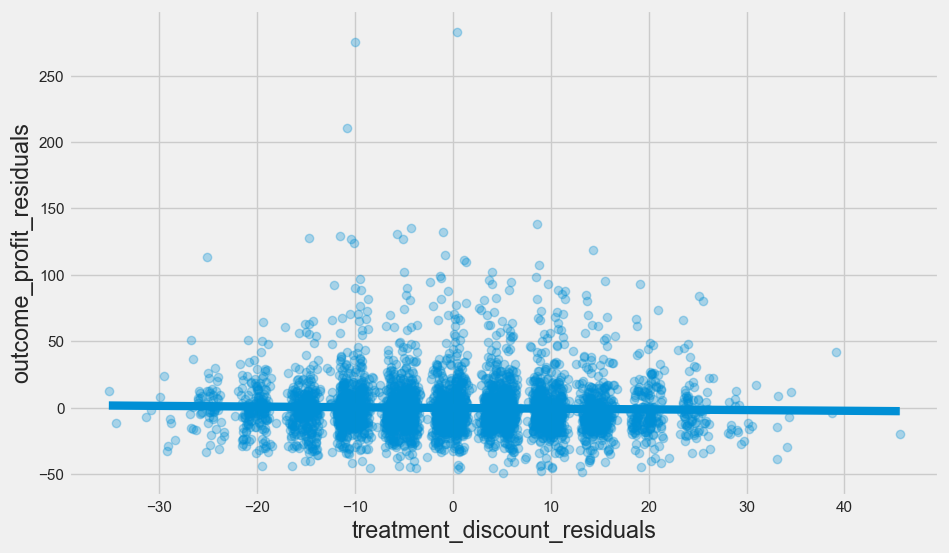

In [7]:
# Debias --------------------------------
debias_formula = "discount ~ age + C(sales_prediction_bins)"
debias_model = smf.ols(debias_formula, train_non_random).fit()
discount_residuals = debias_model.resid

# Denoise --------------------------------
denoise_formula = "profit ~ age + C(sales_prediction_bins)"
denoise_model = smf.ols(denoise_formula, train_non_random).fit()
profit_residuals = denoise_model.resid

#! Note we haven't added back the mean so the residuals are not in the original scale

# Final outcome model -------------------
train_residuals = pd.DataFrame({
    "treatment_discount_residuals": discount_residuals,
    "outcome_profit_residuals": profit_residuals
})

sns.regplot(train_residuals.sample(5000),
            x="treatment_discount_residuals",
            y="outcome_profit_residuals",
            scatter_kws={"alpha": 0.3},)

final_outcome_model = smf.ols("outcome_profit_residuals ~ treatment_discount_residuals",
                              data=train_residuals).fit()
print(final_outcome_model.summary().tables[1])

# Debiasing with Machine Learning

We can use ML models instead of linear regression models to do what we did above. However, the flexibility and power of ML means we have to take into account the possibility of overfitting.

$$
(Y_i - \hat M_y(X_i)) = \beta_1 (T_i - \hat M_t(X_i)) + e_i
$$

Here $\hat M_y(X_i)$ is the outcome estimate predicted by the ML model and $\hat M_x(X_i)$ is the treatment estimate predicted by the model using features $X$.

In order to use the `cust_state` column in our ML model, we need to convert it to a numeric column. We do so by feature engineering a `cust_state_numeric` column that is the average sales of that state.

In [8]:
# Feature engineering a `cust_state_numeric` column
avg_sales_per_state_train = train_non_random.groupby("cust_state")["sales"].mean().to_dict()
avg_sales_per_state_test = test_random.groupby("cust_state")["sales"].mean().to_dict()

train_processed = train_non_random.assign(
    cust_state_numeric = train_non_random["cust_state"].replace(avg_sales_per_state_train)
)

train_processed.head()

test_processed = test_random.assign(
    cust_state_numeric = test_random["cust_state"].replace(avg_sales_per_state_test)
)

## ML Model

In [9]:
not_features = ["sales", "profit", "cust_state", "discount", "sales_prediction", "sales_prediction_bins"]
#? Shouldn't we remove sales_prediction and sales_prediction bins as well?

feature_columns = list(train_processed.drop(columns=not_features).columns)
treatment_column = "discount"

np.random.seed(69)

debias_model = LGBMRegressor(max_depth=3)
treatment_predictions = cross_val_predict(
    debias_model, 
    train_processed[feature_columns], 
    train_processed[treatment_column],
    cv=5)


treatment_residuals = train_non_random[treatment_column] - treatment_predictions
train_debiased = train_processed.assign(discount_residuals = treatment_residuals)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 40
[LightGBM] [Info] Start training from score 78.013333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Text(0.5, 1.0, 'Debiased')

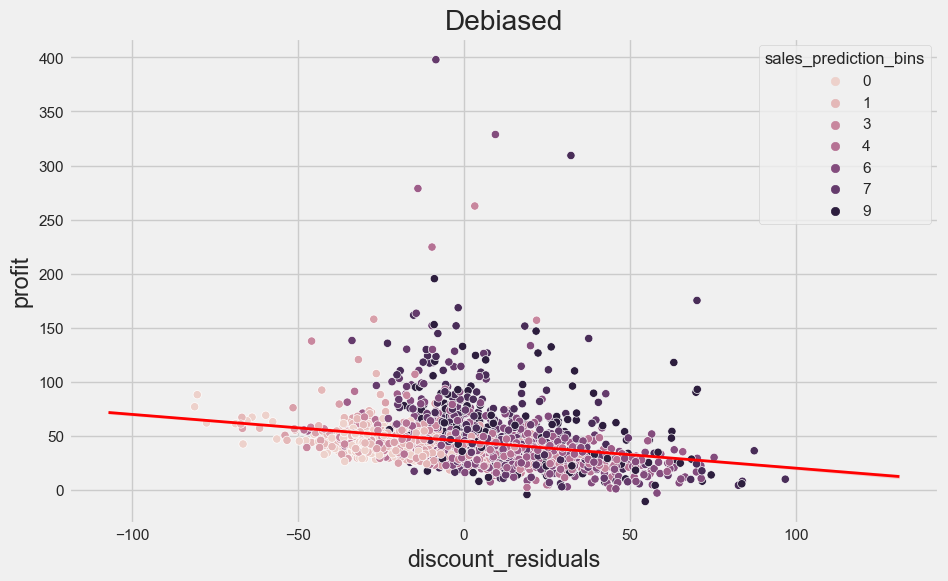

In [10]:
sns.scatterplot(data=train_debiased.sample(2000),
                x="discount_residuals",
                y="profit",
                hue="sales_prediction_bins",)
sns.regplot(x="discount_residuals",
            y="profit",
            data=train_debiased,
            scatter=False,
            color="red",
            line_kws={"lw": 2},)
plt.title("Debiased")

In [11]:
outcome_column = "profit"

np.random.seed(69)

denoise_model = LGBMRegressor(max_depth=3)

outcome_predictions = cross_val_predict(
    denoise_model,
    train_processed[feature_columns],
    train_processed[outcome_column],
    cv=5
)

outcome_residuals = train_processed[outcome_column] - outcome_predictions
train_denoised = train_debiased.assign(
    profit_residuals = outcome_residuals
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 40
[LightGBM] [Info] Start training from score 45.102330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Text(0.5, 1.0, 'Denoised')

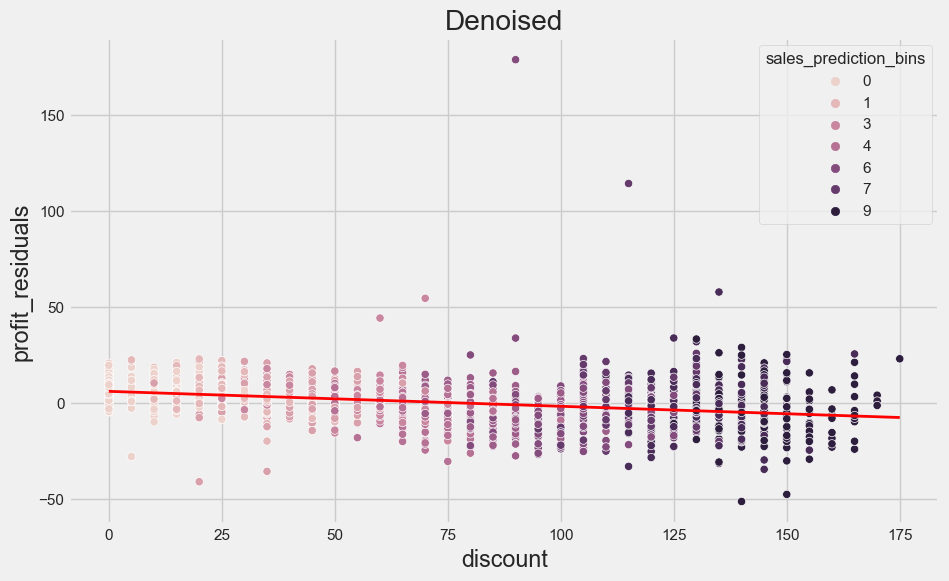

In [12]:
sns.scatterplot(data=train_denoised.sample(2000),
                x="discount",
                y="profit_residuals",
                hue="sales_prediction_bins",)
sns.regplot(x="discount",
            y="profit_residuals",
            data=train_denoised,
            scatter=False,
            color="red",
            line_kws={"lw": 2},)
plt.title("Denoised")

Denoising does not change the direction of the relationship between discount and profits. However, it significantly reduces the variance in the outcome variable (profit). We also notice that denoising and debiasing procedures made the data centered at zero. This might hinder interpretation and we could add the discount and profit averages back into the residualized versions.

In [13]:
final_model = smf.ols("profit_residuals ~ discount_residuals", data=train_denoised).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0564,0.070,0.811,0.417,-0.080,0.193
discount_residuals,-0.2466,0.003,-84.912,0.000,-0.252,-0.241


Text(0.5, 1.0, 'Final Outcome Model')

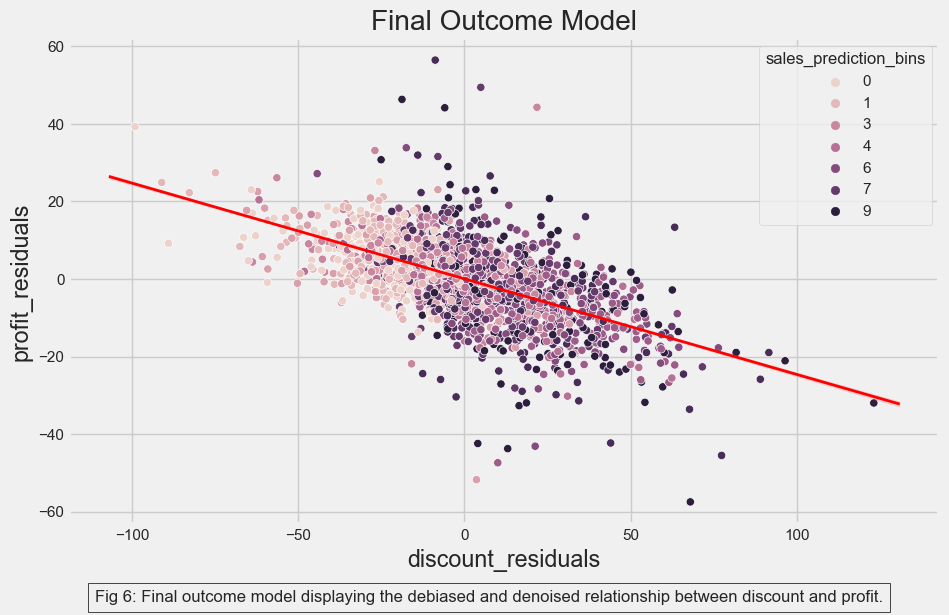

In [65]:
sns.scatterplot(data=train_denoised.sample(2000),
                x="discount_residuals",
                y="profit_residuals",
                hue="sales_prediction_bins",)
sns.regplot(x="discount_residuals",
            y="profit_residuals",
            data=train_denoised,
            scatter=False,
            color="red",
            line_kws={"lw": 2},)
plt.figtext(0.5, 
            -.06, 
            "Fig 6: Final outcome model displaying the debiased and denoised relationship between discount and profit.",
            ha="center", 
            fontsize=12, 
            bbox={"pad":5, "facecolor":"none", "edgecolor":"black"},)            
plt.title("Final Outcome Model")

Using the Double/Debiased ML model also yieled a negative coefficient. It looks like increasing discount by one unit decreases profits by about 0.25 units.

# Personalization using the Double/Debiased ML model
The treatment effect of the double/debiased model is denoted by $\beta_1$ coeffecient in the model below:
$$
(Y_i - \hat M_y(X_i)) = \beta_1 (T_i - \hat M_t(X_i)) + e_i
$$

We allow this treatement effect to change depending on the set of customer features $X$ (age, tenure, state, etc.)
$$
(Y_i - \hat M_y(X_i)) = \tau (X_i) (T_i - \hat M_t(X_i)) + e_i
$$

Let,
$$
(Y_i - \hat M_y(X_i)) = \tilde Y \\
(T_i - \hat M_t(X_i)) = \tilde X \\
\text{then} \ \ \tilde Y = \tau (X_i) \tilde X
$$

To estimate $\tau (X_i)$ we need to train a weighted regression model that predicts $\frac{\tilde Y}{\tilde X}$ from the features $X_i$ using weights $\tilde T_i^2$

In [16]:
train_denoised

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction,cust_state_numeric,discount_residuals,profit_residuals
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,40.06,40,1.0,MA,6,8,1351.024765,2579.424297,23.124232,-7.138570
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,29.52,36,0.0,MG,10,4,1035.580387,2553.222774,-1.773087,-2.430926
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,48.08,34,0.0,RJ,7,3,992.401825,2518.635848,-21.548553,8.438355
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,61.64,31,0.0,BA,7,1,919.720735,2446.648394,-62.462644,6.074889
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,34.44,32,1.0,PB,6,6,1176.485681,2562.461439,29.570651,-0.492975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0.0,50,50.0,430.0,25.0,...,107.57,40,1.0,SP,2,6,1126.246160,2463.130123,-11.735832,13.897179
14996,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,12.46,33,0.0,PI,10,6,1158.199897,2528.931687,10.802914,-23.621817
14997,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,43.21,23,0.0,SP,3,0,800.147253,2463.130123,-20.980561,-1.090882
14998,0,0,0,0,0,0.0,25,0.0,0.0,0.0,...,69.89,43,0.0,BA,4,9,1385.466520,2446.648394,-3.017717,5.520120


In [17]:
len(train_denoised[feature_columns].columns)

40

In [18]:
weights = train_denoised["discount_residuals"] ** 2

target = train_denoised["profit_residuals"] / train_denoised["discount_residuals"]

final_dml_model = LGBMRegressor(max_depth=3)

final_dml_model.fit(X=train_denoised[feature_columns],
                    y=target,
                    sample_weight=weights)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 40
[LightGBM] [Info] Start training from score -0.246569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(max_depth=3)

In [19]:
cate_predictions = final_dml_model.predict(test_processed[feature_columns])
test_predictions = test_processed.assign(CATE = cate_predictions)
test_predictions.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_6m_eletronic,sales,discount,age,gender,cust_state,tenure,profit,cust_state_numeric,CATE
0,0,0,0,0,0,0.0,25,50.0,0.0,0.0,...,0.0,1503.22,20.0,35,1.0,MA,23,55.16,1870.549558,-0.113298
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1798.30,60.0,29,1.0,MG,18,29.92,1865.979271,-0.186072
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1122.97,0.0,30,1.0,RJ,20,56.15,1826.708633,-0.172412
3,10,15,0,25,10,0.0,0,0.0,0.0,0.0,...,0.0,1217.08,10.0,32,0.0,BA,20,50.85,1857.677045,-0.148349
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,966.58,0.0,30,0.0,PB,22,48.33,1823.506774,-0.172412


In [20]:
# Copied from personalization.ipynb

def elast(data: pd.DataFrame, outcome: str, treatment: str):
    covariance_matrix = np.cov(data[outcome], data[treatment])
    covariance = covariance_matrix[0, 1]
    variance_treatment = covariance_matrix[1, 1] 
    linear_causal_effect = covariance / variance_treatment
    
    return linear_causal_effect

def cumulative_treatment_effect(data: pd.DataFrame,
                                segment_column: str,
                                num_segments: int):
    """Calculates the cumulative treatment effect curve.
    
    Returns:
        np.array: array containing the estimated treatment effect for each segment 
    """
    ordered_df = data.sort_values(by=segment_column, ascending=False).reset_index(drop=True)

    indices = (np.arange(1, num_segments + 1) / num_segments * len(ordered_df)).astype(int)

    treatment_effects = np.zeros(num_segments)

    for i, index in enumerate(indices):
        segment = ordered_df.iloc[:index]
        treatment_effects[i] = elast(data=segment,
                                     treatment="discount",
                                     outcome="profit")
    
    return treatment_effects

def cumulative_treatment_gain(data: pd.DataFrame,
                                segment_column: str,
                                num_segments: int):
    """Calculates the cumulative treatment effect curve.

    Args:
        data (pd.DataFrame): _description_
        segment_column (str): _description_
        num_segments (int): _description_

    Returns:
        np.array: array containing the estimated treatment effect for each segment 
    """
    ordered_df = data.sort_values(by=segment_column, ascending=False).reset_index(drop=True)

    percentages = (np.arange(1, num_segments + 1)) / num_segments
    indices = (percentages * len(ordered_df)).astype(int)

    treatment_gains = np.zeros(num_segments)

    for i, index in enumerate(indices):
        segment = ordered_df.iloc[:index]
        treatment_gains[i] = elast(data=segment,
                                    treatment="discount",
                                    outcome="profit")

    return treatment_gains * percentages

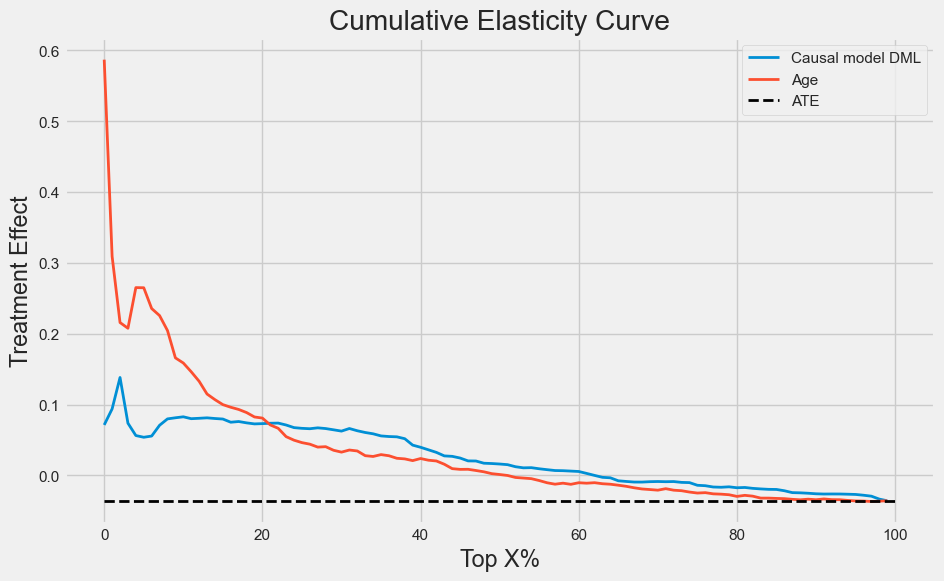

In [27]:
cumulative_te_cate = cumulative_treatment_effect(test_predictions,
                                                 "CATE",
                                                 100)
cumulative_te_age = cumulative_treatment_effect(test_predictions,
                                                "age",
                                                100)
# cumulative_te_ml = cumulative_treatment_effect(train_denoised,
#                                                "sales_prediction",
#                                                100)

plt.plot(cumulative_te_cate, label="Causal model DML", lw=2)
plt.plot(cumulative_te_age, label="Age", lw=2)
# plt.plot(cumulative_te_ml, label="existing", lw=2)
plt.hlines(elast(test_predictions, "profit", "discount"), 0, 100, linestyles="--", color="black", label="ATE", lw=2)
plt.ylabel("Treatment Effect")
plt.xlabel("Top X%")
plt.title("Cumulative Elasticity Curve")

plt.legend()

The cumulative elasticity curve shows that our treatment effect (TE) model starts on the positive side and converges to the ATE slower than age. Our model is better at distinguishing custoemrs with high TE from those with low TE, though not by much.

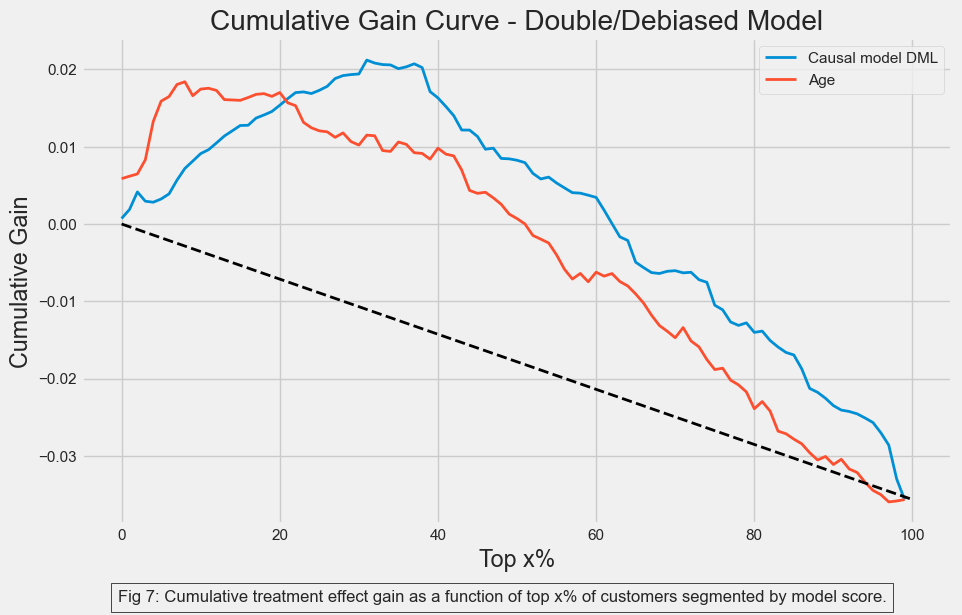

In [66]:
cumulative_gain_cate = cumulative_treatment_gain(test_predictions, "CATE", 100)
cumulative_gain_age = cumulative_treatment_gain(test_predictions, "age", 100)
cumulative_gain_age = cumulative_treatment_gain(test_predictions, "age", 100)

plt.plot(cumulative_gain_cate, label="Causal model DML", lw=2)
plt.plot(cumulative_gain_age, label="Age", lw=2)
plt.plot([0, 100], [0, elast(test_predictions, "profit", "discount")], linestyle="--", color="black", lw=2)
plt.title("Cumulative Gain Curve - Double/Debiased Model")
plt.ylabel("Cumulative Gain")
plt.xlabel("Top x%")
plt.figtext(0.5, 
            -.06, 
            "Fig 7: Cumulative treatment effect gain as a function of top x% of customers segmented by model score.",
            ha="center", 
            fontsize=12, 
            bbox={"pad":5, "facecolor":"none", "edgecolor":"black"},)
plt.legend()

The cumulative gain curve gives us more color. While Age is better at distinguishing customers with a high positive treatment effect (age curve starts out above our model's curve), our mode is clearly better to distinguish customers with a low and high treatment effects overall.

# Recommendation

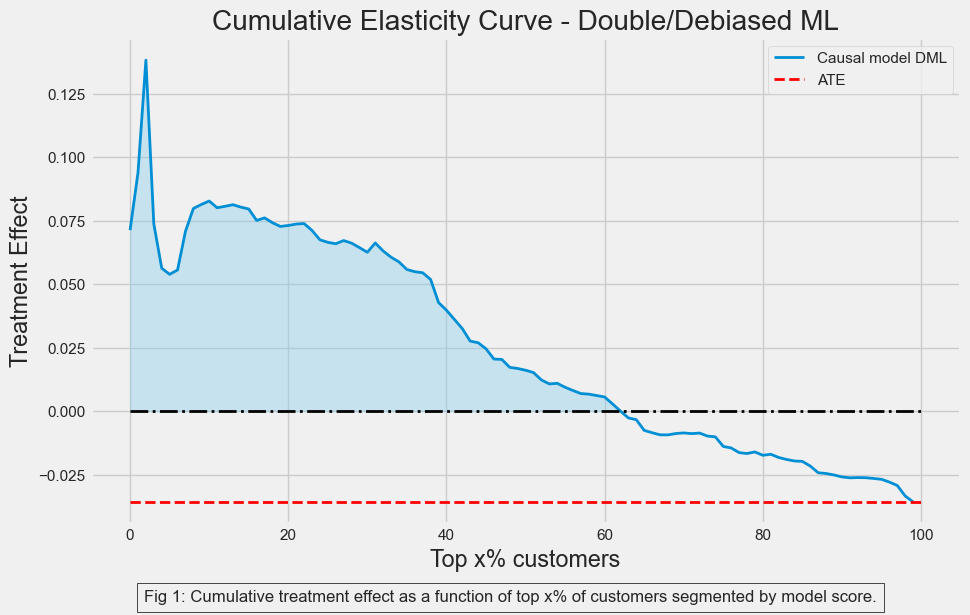

In [63]:
plt.plot(cumulative_te_cate, label="Causal model DML", lw=2)
plt.hlines(elast(test_predictions, "profit", "discount"), 0, 100, linestyles="--", color="red", label="ATE", lw=2)
plt.hlines(0, 0, 100, linestyles="dashdot", lw=2, color="black")
plt.fill_between(range(len(cumulative_te_cate)), cumulative_te_cate, where=[y > 0 for y in cumulative_te_cate], interpolate=True, color='skyblue', alpha=0.4)

plt.ylabel("Treatment Effect")
plt.xlabel("Top x% customers")
plt.title("Cumulative Elasticity Curve - Double/Debiased ML")
plt.figtext(0.5, 
            -.06, 
            "Fig 1: Cumulative treatment effect as a function of top x% of customers segmented by model score.",
            ha="center", 
            fontsize=12, 
            bbox={"pad":5, "facecolor":"none", "edgecolor":"black"},)
plt.legend()

In [ ]:
sum(cumulative_te_cate > 0)

63

The cumulative elasticity curve suggests that if we sort customers according to the treatment effect model, the top 63% would have a positive treatment effect. Keeping to the conservative side, **we recommend that the e-commerce company give discounts to customers with TE prediction above the 55th percentile.**